#                      >>>>>    CNN Model for Cat Vs Dog Prediction  <<<<<

* Nishant Raghuwanshi
* 09/29/2023
* 9:50 PM

# **Convolutional Neural Network Model Structure for Image Classification**

![CNN Model structure](https://miro.medium.com/v2/resize:fit:1400/1*7_BCJFzekmPXmJQVRdDgwg.png)

# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import keras_tuner
import tensorflow
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Sample Image

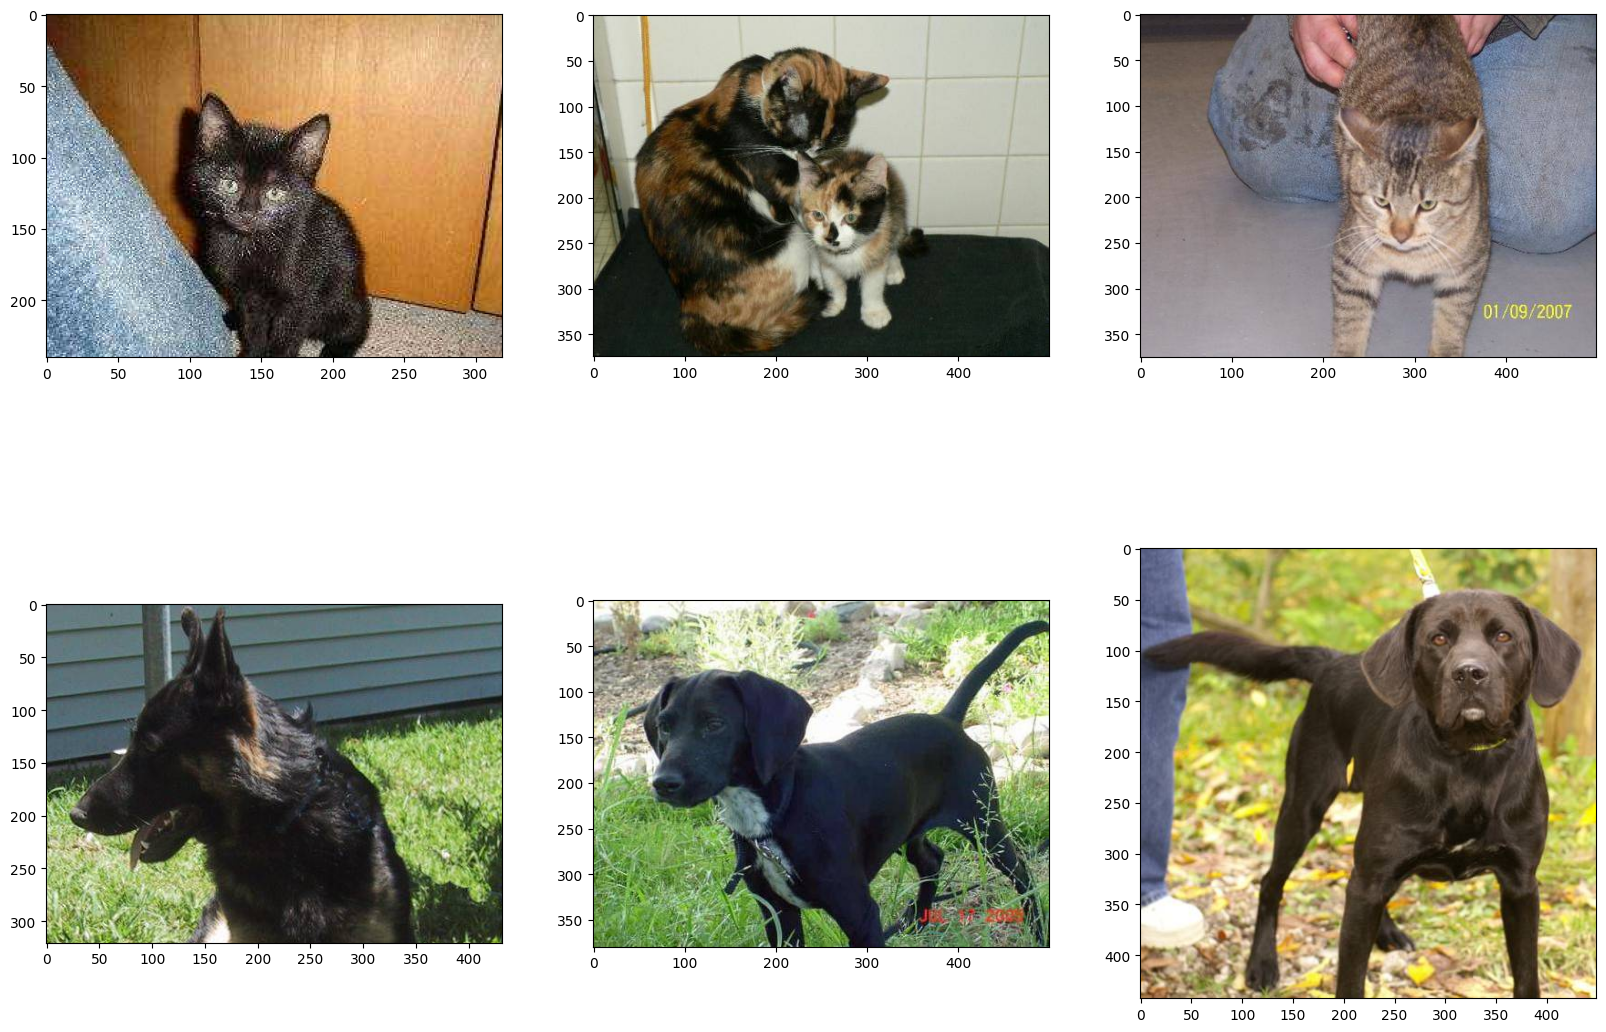

In [2]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_directory = '/kaggle/input/dogs-vs-cats/train/cats'
image_directory2 = '/kaggle/input/dogs-vs-cats/train/dogs'
image_files = [os.path.join(image_directory, filename) for filename in os.listdir(image_directory)]
image_files2 = [os.path.join(image_directory2,filename) for filename in os.listdir(image_directory2)]
num_samples = 3  
selected_images = random.sample(image_files, num_samples)
selected_images2 = random.sample(image_files2,num_samples)
# Create subplots for displaying images
fig, axes = plt.subplots(2, num_samples, figsize=(20,14))

# Display each selected image
for i, image_path in enumerate(selected_images):
    ax = axes[0,i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.axis()
for i, image_path in enumerate(selected_images2):
    ax = axes[1,i]
    img = mpimg.imread(image_path)
    ax.imshow(img)
    ax.axis()
# Show the images
plt.show()


We use generator because we have more than 10000 images

# **Train Data**

In [3]:
train_data = keras.utils.image_dataset_from_directory(directory= '/kaggle/input/dogs-vs-cats/train',
                                                     labels= 'inferred',
                                                     label_mode= 'int',
                                                     color_mode='rgb',
                                                     batch_size= 32,
                                                     image_size=(256,256))

Found 20000 files belonging to 2 classes.


# **Test Data**

In [4]:
validation_data = keras.utils.image_dataset_from_directory(directory= '/kaggle/input/dogs-vs-cats/test',
                                                    labels = 'inferred',
                                                    label_mode= 'int',
                                                    color_mode= 'rgb',
                                                    batch_size= 32,
                                                    image_size=(256,256))

Found 5000 files belonging to 2 classes.


# **Data Normalization**

In [5]:
def process(image,label):
    image = tensorflow.cast(image/255, dtype= 'float32')
    return image,label
train_data = train_data.map(process)
validation_data = validation_data.map(process)

In [6]:
print(train_data)
print(validation_data)

<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


# **Creating CNN Model**

In [7]:
def build_model(hp):
    model = keras.Sequential()
    num_conv_layer = hp.Int('num_conv_layer', min_value = 1, max_value = 5, step = 1)
    for i in range(num_conv_layer):
        model.add(keras.layers.Conv2D(filters = hp.Int(f'conv_{i}_filters', min_value = 32,
                                                      max_value = 256, step = 32),
                                     kernel_size= (3,3), padding = 'valid',activation= keras.activations.relu,
                                      input_shape = (256, 256, 3)))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.MaxPooling2D(pool_size= (2,2)))
    model.add(keras.layers.Flatten())
    
    #Tuning the numbre of dense layers...
    num_dense_layer = hp.Int('num_dense_layer', min_value = 1, max_value = 5, step = 1)
    for i in range(num_dense_layer):
        model.add(keras.layers.Dense(units= hp.Int(f'unit_{i}_layer', min_value = 32, max_value = 512,
                                                  step = 32),
                                    activation= keras.activations.relu,
                                    kernel_regularizer= keras.regularizers.l2(0.001)))
        model.add(keras.layers.Dropout(rate=hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(keras.layers.Dense(1 , activation= keras.activations.sigmoid))
    
    learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])
    model.compile(optimizer = keras.optimizers.Adam(learning_rate= learning_rate, amsgrad= True),
                 loss = keras.losses.binary_crossentropy,
                 metrics = ['accuracy'])
    return model
        

In [8]:
tuner = keras_tuner.RandomSearch(hypermodel = build_model, objective = 'val_accuracy',
                                max_trials = 4, max_retries_per_trial = 3,
                                directory = '/kaggle/working/',
                                project_name = 'Cat_vs_dog') 

In [9]:
tuner.search(train_data, epochs = 5, validation_data = validation_data)

Trial 4 Complete [00h 18m 14s]
val_accuracy: 0.7746000289916992

Best val_accuracy So Far: 0.8539999723434448
Total elapsed time: 00h 37m 54s


In [15]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [16]:

model1 = tuner.hypermodel.build(best_hps)


# **Our Convolutional Model**

In [17]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 batch_normalization_2 (Batc  (None, 254, 254, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 96)      55392     
                                                                 
 batch_normalization_3 (Batc  (None, 125, 125, 96)     384       
 hNormalization)                                                 
                                                      

# **Model Training**

In [18]:
history = model1.fit_generator(train_data,steps_per_epoch= len(train_data) ,epochs = 50, 
                               validation_data= validation_data, validation_steps= len(validation_data) )

Epoch 1/50


/tmp/ipykernel_71/1528098751.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model1.fit_generator(train_data,steps_per_epoch= len(train_data) ,epochs = 50,


625/625 [==============================] - 112s 170ms/step - loss: 0.9628 - accuracy: 0.5964 - val_loss: 0.8928 - val_accuracy: 0.5762
Epoch 2/50
625/625 [==============================] - 105s 167ms/step - loss: 0.7479 - accuracy: 0.7253 - val_loss: 0.7338 - val_accuracy: 0.7158
Epoch 3/50
625/625 [==============================] - 115s 183ms/step - loss: 0.6311 - accuracy: 0.7870 - val_loss: 0.6742 - val_accuracy: 0.7490
Epoch 4/50
625/625 [==============================] - 115s 183ms/step - loss: 0.5415 - accuracy: 0.8329 - val_loss: 0.6040 - val_accuracy: 0.7854
Epoch 5/50
625/625 [==============================] - 105s 168ms/step - loss: 0.4576 - accuracy: 0.8792 - val_loss: 0.5279 - val_accuracy: 0.8468
Epoch 6/50
625/625 [==============================] - 115s 183ms/step - loss: 0.3946 - accuracy: 0.9089 - val_loss: 0.6655 - val_accuracy: 0.7852
Epoch 7/50
625/625 [==============================] - 115s 183ms/step - loss: 0.3459 - accuracy: 0.9291 - val_loss: 0.6077 - val_accura

# **Graph Between accuracy Vs val_accuracy**

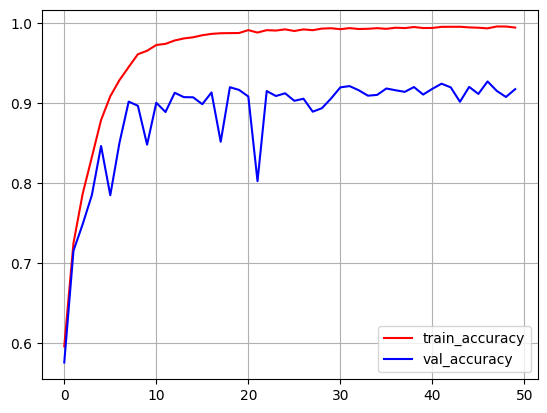

In [19]:
plt.plot(history.history['accuracy'], color = 'red',label = 'train_accuracy' )
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'val_accuracy')
plt.legend()
plt.grid()
plt.plot()
plt.show()

# **Graph Between loss Vs val_loss**

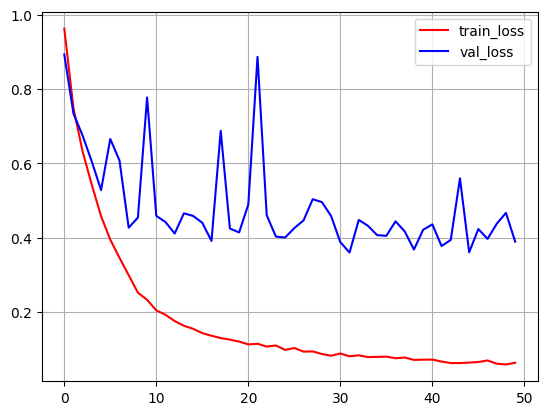

In [20]:
plt.plot(history.history['loss'], color = 'red', label = 'train_loss')
plt.plot(history.history['val_loss'], color = 'blue', label = 'val_loss')
plt.legend()
plt.grid()
plt.plot()
plt.show()

# **Retrain the model till the best number of epochs**

In [21]:
val_acc_per_epochs = history.history['val_accuracy']
best_epoch = val_acc_per_epochs.index(max(val_acc_per_epochs)) + 1
hypermodel = tuner.hypermodel.build(best_hps)

In [22]:
hypermodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 64)      1792      
                                                                 
 batch_normalization_6 (Batc  (None, 254, 254, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 64)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 96)      55392     
                                                                 
 batch_normalization_7 (Batc  (None, 125, 125, 96)     384       
 hNormalization)                                                 
                                                      

In [24]:
#Retrain the model....
hypermodel.fit(train_data,steps_per_epoch= len(train_data) ,epochs = best_epoch, 
                               validation_data= validation_data, validation_steps= len(validation_data))


Epoch 1/47
625/625 [==============================] - 120s 182ms/step - loss: 0.9399 - accuracy: 0.6089 - val_loss: 0.8147 - val_accuracy: 0.6838
Epoch 2/47
625/625 [==============================] - 105s 167ms/step - loss: 0.7154 - accuracy: 0.7424 - val_loss: 0.7598 - val_accuracy: 0.7026
Epoch 3/47
625/625 [==============================] - 105s 167ms/step - loss: 0.6096 - accuracy: 0.7943 - val_loss: 0.5904 - val_accuracy: 0.8016
Epoch 4/47
625/625 [==============================] - 114s 182ms/step - loss: 0.5104 - accuracy: 0.8472 - val_loss: 0.5058 - val_accuracy: 0.8534
Epoch 5/47
625/625 [==============================] - 114s 182ms/step - loss: 0.4233 - accuracy: 0.8888 - val_loss: 0.4882 - val_accuracy: 0.8622
Epoch 6/47
625/625 [==============================] - 104s 166ms/step - loss: 0.3749 - accuracy: 0.9155 - val_loss: 0.4525 - val_accuracy: 0.8746
Epoch 7/47
625/625 [==============================] - 114s 182ms/step - loss: 0.3237 - accuracy: 0.9348 - val_loss: 0.4097 -

# **Prediction on an image**

In [3]:
test_data = keras.utils.image_dataset_from_directory(directory= '/kaggle/input/cat-vs-dog-test1/Cat_vs_dog_test',
                                                     image_size=(256,256))

Found 13 files belonging to 2 classes.


In [ ]:
prediction = hypermodel.predict_generator(test_data)
prediction = (prediction>0.5).astype(float)

In [89]:
prediction

array([[0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.]])